In [14]:
from os.path import join
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATA_DIR = '../data/01_processed'

In [5]:
tracking = pd.read_parquet(join(DATA_DIR, 'tracking.parquet'))
plays = pd.read_parquet(join(DATA_DIR, 'plays.parquet'))
games = pd.read_parquet(join(DATA_DIR, 'games.parquet'))
player_play = pd.read_parquet(join(DATA_DIR, 'player_play.parquet'))

# 1. Aggregate field control within RB vision cone
Apply this over the frames until the rb passes beyond the oline influence, to quantify how much space the rb has to run through. One possible limitation to this approach is rb skill will also likely lead to more open space, due to better vision, speed, or agility.

#### Calculate the euclidean distance from the ball carrier to each player for each frame 

In [6]:
rb_coords = (
    tracking[tracking['is_ball_carrier'] == 1]
    .set_index(['game_play_id', 'frame_id'])[['x', 'y']]
    .rename(columns={'x': 'ball_carrier_x', 'y': 'ball_carrier_y'})
)

tracking = tracking.merge(
    rb_coords,
    left_on=['game_play_id', 'frame_id'],
    right_index=True,
    how='left'
)

tracking['euclidean_dist_to_ball_carrier'] = (
    ((tracking['x'] - tracking['ball_carrier_x']) ** 2 +
     (tracking['y'] - tracking['ball_carrier_y']) ** 2) ** 0.5
).round(2)

tracking.drop(columns=['ball_carrier_x', 'ball_carrier_y'], inplace=True)

#### Find the closest offensive player to each defender. Mark the defender as engaged if they are within 3 feet of the offensive player

In [7]:
defenders = tracking[(tracking['offense'] == 0) & (tracking['club'] != 'football')].copy()
offense = tracking[(tracking['offense'] == 1) & (tracking['club'] != 'football')].copy()

defenders = defenders.rename(columns={'nfl_id': 'def_nfl_id', 'x': 'def_x', 'y': 'def_y'})
offense = offense.rename(columns={'nfl_id': 'off_nfl_id', 'x': 'off_x', 'y': 'off_y'})

merged = defenders.merge(
    offense[['game_play_id', 'frame_id', 'off_nfl_id', 'off_x', 'off_y']],
    on=['game_play_id', 'frame_id'],
    how='left'
)

merged['dist'] = np.sqrt((merged['def_x'] - merged['off_x'])**2 + (merged['def_y'] - merged['off_y'])**2)

merged = merged.sort_values(['game_play_id', 'frame_id', 'def_nfl_id', 'dist'])

# Get closest offensive player to each defender
closest = merged.loc[
    merged.groupby(['game_play_id', 'frame_id', 'def_nfl_id'])['dist'].idxmin(),
    ['game_play_id', 'frame_id', 'def_nfl_id', 'def_x', 'def_y', 
     'off_nfl_id', 'off_x', 'off_y', 'dist']
].copy()

# Rename columns
closest = closest.rename(columns={
    'off_x': 'x_closest_off_player',
    'off_y': 'y_closest_off_player',
    'off_nfl_id': 'closest_off_nfl_id',
    'dist': 'closest_off_dist'
})

# Mark engagement (3 feet == 1 yard)
closest['engaged'] = closest['closest_off_dist'] < 1

# Merge back to original tracking data
tracking = tracking.merge(
    closest[['game_play_id', 'frame_id', 'def_nfl_id', 'x_closest_off_player', 'y_closest_off_player', 'engaged']],
    left_on=['game_play_id', 'frame_id', 'nfl_id'],
    right_on=['game_play_id', 'frame_id', 'def_nfl_id'],
    how='left'
).drop(columns=['def_nfl_id'])

tracking['engaged'] = tracking['engaged'].fillna(False).astype(bool)

In [8]:
tracking.position_by_loc.value_counts(normalize=True)

CB     0.111145
WR     0.104182
TE     0.067632
OLB    0.066414
DT     0.065638
DE     0.064903
ILB    0.063432
FS     0.050935
RB     0.046968
SS     0.046252
QB     0.045468
RG     0.045455
C      0.045455
LG     0.045455
LT     0.045455
RT     0.045455
NT     0.019420
MLB    0.011034
FB     0.008451
LB     0.000641
DB     0.000212
Name: position_by_loc, dtype: float64

In [9]:
tracking.query('position_by_loc.isin(["OLB","DT","DE","ILB","NT","MLB","LB"])').engaged.value_counts(normalize=True)

True     0.575566
False    0.424434
Name: engaged, dtype: float64

#### Field Control functions

In [10]:
def influence(
        p: np.ndarray,
        p_i: np.ndarray,
        s: float,
        theta: float,
        rb_dist: float,
        is_offense: bool,
    ):
    '''
    Calculate the influence of a player on a point in the field.

    Args:
        p: coordinates of the point in the field.
        p_i: coordinates of the player.
        s: speed of the player.
        theta: direction of the player in radians.
        rb_dist: distance to the ball carrier.
        is_offense: boolean indicating if the player is on offense.
    Returns:    
        Influence value at the point.
    '''
    influence = (
        _bivariate_gaussian_pdf(p, p_i, s, theta, rb_dist) /
        _bivariate_gaussian_pdf(p_i, p_i, s, theta, rb_dist)
    )

    if is_offense:
        return influence
    return -influence

def _piecewise_function(x):
    """ Function reduces influence area radius if a player is closer to the rb """
    if x <= 18:
        return 0.01854*x**2 + 4  # Parabola for x <= 18
    else:
        return 10  # Flat line at y = 10 for x > 18

def _rotation_matrix(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])

def _speed_ratio(s):
    return s**2 / 13**2
    
def _scaling_matrix(rb_dist, s):
    R = _piecewise_function(rb_dist)
    s_ratio = _speed_ratio(s)
    s_x = (R + (R * s_ratio)) / 2
    s_y = (R - (R * s_ratio)) / 2
    return np.array([[s_x,0],[0,s_y]])

def _mu(p_i, s_vect):
    s_unit_vector = s_vect / np.linalg.norm(s_vect)
    return p_i + (.5 * s_unit_vector)

def _cov(theta, rb_dist, s):
    S = _scaling_matrix(rb_dist, s)
    R = _rotation_matrix(theta)
    return R @ S @ S @ np.linalg.inv(R)

def _bivariate_gaussian_pdf(
    p: np.ndarray,
    p_i: np.ndarray,
    s: float,
    theta: float,
    rb_dist: float
):
    """
    Calculate the bivariate Gaussian PDF for a point in the field.
    
    Args:
        p: coordinates of the point in the field (2D vector).
        p_i: coordinates of the player (2D vector).
        s: player speed (float).
        theta: direction of motion in radians.
        rb_dist: Euclidean distance to the ball carrier.
        
    Returns:
        Float: PDF value at point p.
    """
    s_x = s * np.cos(theta)
    s_y = s * np.sin(theta)
    s_vect = np.array([s_x, s_y])
    
    mu = _mu(p_i, s_vect)
    sigma = _cov(theta, rb_dist, s)
    
    diff = p - mu
    constant = 1 / (2 * np.pi * np.sqrt(np.linalg.det(sigma)))
    exponent = -0.5 * diff.T @ np.linalg.inv(sigma) @ diff
    return constant * np.exp(exponent)

#### Visualize the field control within the ball carriers vision cone. This is filtered down to the frames of a play where the oline blocking has the greatest effect

In [11]:
plays.query('game_play_id == "2022091104_1917"').play_description.values[0]

'(4:34) D.Swift left tackle to PHI 29 for 13 yards (M.Epps).'

In [13]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from shapely import MultiPoint
import sys

game_play_id = '2022091104_1917'

df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
frame_ids = sorted(df_all['frame_id'].unique())
yardline = plays.query('game_play_id == @game_play_id').absolute_yardline_number.values[0]

field_control_granularity = 1
xmin, xmax = 0, 53.3

fig, ax = plt.subplots(figsize=(10, 8))

def create_mesh(df):
    ybuffer = 1
    ymin, ymax = df['y'].min() - ybuffer, df['y'].max() + ybuffer
    X, Y = np.meshgrid(np.arange(xmin, xmax + field_control_granularity, field_control_granularity),
                       np.arange(ymin, ymax + field_control_granularity, field_control_granularity))
    coords = np.column_stack([X.ravel(), Y.ravel()]).reshape((X.shape[0], X.shape[1], 2))
    return X, Y, coords

def compute_field_control(frame_df, coords):
    smoothing_param = sys.float_info.epsilon
    grid_shape = coords.shape[:2]
    field_control = np.zeros(grid_shape)

    cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier',
            'x_closest_off_player', 'y_closest_off_player', 'engaged']
    for i, row_coords in enumerate(coords):
        for j, coord in enumerate(row_coords):
            for row in frame_df[cols].itertuples(index=False):
                scale = 1
                # If defender is engaged, reduce their influence based on angle to closest offensive player
                if row.engaged:
                    # angle formed from defender to closest offensive player to the point
                    # the scale is (180 - angle) / 180
                    defender_pos = np.array([row.x, row.y])
                    off_player_pos = np.array([row.x_closest_off_player, row.y_closest_off_player])
                    point_pos = np.array(coord)
                    vec_def_to_off = off_player_pos - defender_pos
                    vec_point_to_off = off_player_pos - point_pos
                    angle = np.degrees(np.arccos(
                        np.dot(vec_def_to_off, vec_point_to_off) /
                        (np.linalg.norm(vec_def_to_off) * np.linalg.norm(vec_point_to_off) + 1e-8)
                    ))
                
                    # Scale factor ranges from 0 (180°) to 1 (0°) to the square root of the scale (make it more gradual)
                    scale = ((180 - angle) / 180) ** .5
                    scale = np.clip(scale, 0, 1)
                    
                field_control[i, j] += scale * influence(
                    p=coord,
                    p_i=np.array([row.x, row.y]),
                    s=row.s + smoothing_param,
                    theta=row.dir * np.pi / 180,
                    rb_dist=row.euclidean_dist_to_ball_carrier,
                    is_offense=row.offense
                )

    return 1 / (1 + np.exp(-field_control))  # sigmoid normalization

def get_vision_cone(rb_pos, rb_dir_rad, rb_speed, cone_angle_deg=45, min_length=3, speed_factor=0.3):
    """
    Returns properly angled semi-elliptical cone with correct width
    - cone_angle_deg: Total angular width (now correctly 45 degrees)
    - min_length: minimum cone length in yards
    - speed_factor: how much speed affects cone length
    """
    cone_length = min_length + rb_speed * speed_factor
    
    # Create points for the curved front (semi-ellipse)
    t = np.linspace(-np.radians(cone_angle_deg/2), np.radians(cone_angle_deg/2), 20)
    ellipse_x = cone_length * np.cos(t)
    ellipse_y = cone_length * np.sin(t) * 0.7
    
    points = np.column_stack([np.concatenate([[0], ellipse_x]),
                             np.concatenate([[0], ellipse_y])])
    
    # Rotate to face RB direction
    rot_matrix = np.array([[np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
                          [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]])
    rotated_points = (rot_matrix @ points.T).T
    
    # Translate to field position
    return rotated_points + rb_pos

def get_rb_semicircle(rb_pos, rb_dir_rad, radius=1.5, num_points=50, cone_angle_deg=45):
    """
    Return arc points for a circle around RB excluding the vision cone wedge.
    
    rb_pos: np.array([x, y])
    rb_dir_rad: RB facing direction in radians
    radius: radius of the circle in yards
    num_points: total number of points around the arc
    cone_angle_deg: angular width of vision cone to exclude
    """
    # Full 360° except the cone's wedge
    excluded_half_angle = np.radians(cone_angle_deg / 2)
    
    # Angles will cover 360° minus the wedge
    # Start just outside the cone wedge on the left, sweep around behind RB, 
    # and stop just before the cone wedge on the right
    start_angle = excluded_half_angle
    end_angle = 2 * np.pi - excluded_half_angle
    
    # Generate arc points
    angles = np.linspace(start_angle, end_angle, num_points)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    
    # Add center point for polygon closing
    points = np.column_stack([np.concatenate([[0], x]),
                               np.concatenate([[0], y])])
    
    # Rotate arc so the excluded wedge is aligned with RB direction
    rot_matrix = np.array([[np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
                           [np.sin(rb_dir_rad),  np.cos(rb_dir_rad)]])
    rotated_points = (rot_matrix @ points.T).T
    
    return rotated_points + rb_pos

def calculate_combined_fc(fc, coords, polygons):
    """
    polygons: list of vertex arrays.
    Returns FC mean in the union of polygons.
    """
    combined_mask = np.zeros(coords.shape[:2], dtype=bool)
    for vertices in polygons:
        path = Path(vertices)
        mask = path.contains_points(coords.reshape(-1, 2)).reshape(coords.shape[:2])
        combined_mask |= mask
    return fc[combined_mask].mean() if np.any(combined_mask) else 0

# def calculate_cone_field_control(fc, coords, cone_vertices):
#     """Improved version using path contains_points"""
#     from matplotlib.path import Path
#     path = Path(cone_vertices)
#     mask = path.contains_points(coords.reshape(-1, 2)).reshape(coords.shape[:2])
#     return fc[mask].mean() if np.any(mask) else 0

X_global, Y_global, coords_global = create_mesh(df_all)

cone_stats = {'frame_values': [], 'average': 0}

def update(frame_id):
    ax.clear()
    frame_df = df_all[df_all['frame_id'] == frame_id]
    
    ymin, ymax = frame_df['y'].min() - 1, frame_df['y'].max() + 1
    X, Y, coords = create_mesh(frame_df)
    fc = compute_field_control(frame_df, coords)
    
    ax.imshow(fc, extent=[xmin, xmax, ymin, ymax], origin='lower', cmap='coolwarm', alpha=0.5, aspect='auto')
    
    points = [tuple(v) for v in frame_df.query('is_part_of_oline')[['x', 'y']].values.tolist()]
    if len(points) >= 3:
        convex_hull = MultiPoint(points).convex_hull
        x, y = convex_hull.exterior.xy
        ax.plot(x, y, color='darkred', linewidth=2, label='Convex Hull of O-Line')
    
    rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
    if not rb_data.empty:
        rb = rb_data.iloc[0]
        rb_pos = np.array([rb.x, rb.y])
        rb_dir_rad = rb.dir * np.pi / 180
        rb_speed = rb.s
        
        cone_vertices = get_vision_cone(rb_pos, rb_dir_rad, rb_speed)
        semicircle_vertices = get_rb_semicircle(rb_pos, rb_dir_rad, radius=1.5)
        
        # Draw cone
        ax.add_patch(plt.Polygon(cone_vertices, color='black', alpha=0.8, linewidth=2, fill=False))
        # Draw semicircle
        ax.add_patch(plt.Polygon(semicircle_vertices, color='black', alpha=0.8, linewidth=2, fill=False))
        
        combined_fc = calculate_combined_fc(fc, coords, [cone_vertices, semicircle_vertices])
        cone_stats['frame_values'].append(combined_fc)
        
        ax.text(0.02, 0.95, f"Current FC (cone+semicircle): {combined_fc:.2f}", 
                transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    # add black line as vision cone to legend
    ax.plot([], [], color='black', alpha=0.8, linewidth=2, label='RB Vision Cone')
    
    oline = frame_df[frame_df['is_part_of_oline']]
    rb = frame_df[frame_df['is_ball_carrier'] == 1]
    defense = frame_df[(frame_df['offense'] == 0)]
    offense = frame_df[(frame_df['offense'] == 1) & (~frame_df['is_part_of_oline'])]

    ax.scatter(oline['x'], oline['y'], label='O-Line', s=50, color='red', zorder=2)
    ax.scatter(rb['x'], rb['y'], label='Ball Carrier', s=50, color='darkred', zorder=3)
    ax.scatter(defense['x'], defense['y'], label='Defense', s=50, color='blue', zorder=2)
    ax.scatter(offense['x'], offense['y'], label='Offense', s=50, color='#f28383', zorder=2)

    ax.hlines(yardline, 0, 53.3, color='green', linestyle='--', label='Line of Scrimmage')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal', adjustable='box')
    
    if frame_id == frame_ids[-1]:
        cone_stats['average'] = np.mean(cone_stats['frame_values'])
        ax.text(0.02, 0.90, f"Avg FC in cone (across relevant frames): {cone_stats['average']:.2f}", 
                transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(f'Field Control + Vision Cone\nFrame {frame_id}')
    ax.legend(bbox_to_anchor=(.8, 1.6), loc='upper left')

ani = FuncAnimation(fig, update, frames=frame_ids, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [18]:
tracking.position_by_loc.unique()

array(['SS', 'QB', 'RG', 'CB', 'OLB', 'WR', 'DE', 'ILB', 'FS', 'C', 'NT',
       'RB', 'TE', 'LG', 'LT', 'RT', None, 'DT', 'MLB', 'FB', 'LB', 'DB'],
      dtype=object)

In [17]:
import numpy as np
from matplotlib.path import Path
# ['SS', 'QB', 'RG', 'CB', 'OLB', 'WR', 'DE', 'ILB', 'FS', 'C', 'NT',
#        'RB', 'TE', 'LG', 'LT', 'RT', None, 'DT', 'MLB', 'FB', 'LB', 'DB']
def_positions = ['SS', 'CB', 'OLB', 'DE', 'ILB', 'FS', 'NT',
      'DT', 'MLB', 'LB', 'DB']
off_positions = ['QB', 'WR', 'TE', 'RB', 'FB', 'C', 'LG', 'RG', 'LT', 'RT']
tracking['defense'] = tracking['position_by_loc'].isin(def_positions)

def calculate_play_rb_field_control(game_play_id, cone_granularity=0.1):
    """Calculate average field control in RB's merged vision+semicircle polygon, 
    with engaged scaling factor applied."""
    smoothing_param = sys.float_info.epsilon
    
    df_all = tracking.query('game_play_id == @game_play_id and club != "football"').copy()
    frame_ids = sorted(df_all['frame_id'].unique())
    cone_stats = {'frame_values': [], 'average': 0}
    
    for frame_id in frame_ids:
        frame_df = df_all[df_all['frame_id'] == frame_id]
        rb_data = frame_df[frame_df['is_ball_carrier'] == 1]
        
        if not rb_data.empty:
            rb = rb_data.iloc[0]
            rb_pos = np.array([rb.x, rb.y])
            rb_dir_rad = rb.dir * np.pi / 180
            rb_speed = rb.s
            
            # Build merged cone+circle shape
            cone_vertices = get_rb_vision_plus_circle(rb_pos, rb_dir_rad, rb_speed)
            path = Path(cone_vertices)
            
            # Grid around the polygon
            cone_buffer = 2  # yards buffer
            x_min, x_max = cone_vertices[:, 0].min() - cone_buffer, cone_vertices[:, 0].max() + cone_buffer
            y_min, y_max = cone_vertices[:, 1].min() - cone_buffer, cone_vertices[:, 1].max() + cone_buffer
            
            X = np.arange(x_min, x_max + cone_granularity, cone_granularity)
            Y = np.arange(y_min, y_max + cone_granularity, cone_granularity)
            X, Y = np.meshgrid(X, Y)
            coords = np.column_stack([X.ravel(), Y.ravel()])
            
            # Keep only points inside the polygon
            mask = path.contains_points(coords)
            cone_coords = coords[mask]
            
            if len(cone_coords) > 0:
                fc_values = np.zeros(len(cone_coords))
                
                cols = [
                    'x', 'y', 's', 'dir', 'offense',
                    'euclidean_dist_to_ball_carrier',
                    'x_closest_off_player', 'y_closest_off_player', 'engaged',
                    # 'defense'
                ]
                
                for i, coord in enumerate(cone_coords):
                    for row in frame_df[cols].itertuples(index=False):
                        # Only consider defenders
                        # if not row.defense:
                        #     continue

                        # scale = 1
                        
                        # Engaged scaling factor
                        # if row.engaged:
                        #     defender_pos = np.array([row.x, row.y])
                        #     off_player_pos = np.array([row.x_closest_off_player, row.y_closest_off_player])
                        #     point_pos = np.array(coord)
                            
                        #     vec_def_to_off = off_player_pos - defender_pos
                        #     vec_point_to_off = off_player_pos - point_pos
                            
                        #     # Avoid division by zero
                        #     dot_prod = np.dot(vec_def_to_off, vec_point_to_off)
                        #     norm_prod = (np.linalg.norm(vec_def_to_off) * np.linalg.norm(vec_point_to_off) + 1e-8)
                        #     angle = np.degrees(np.arccos(dot_prod / norm_prod))
                            
                        #     # Scale factor (0 at 180°, 1 at 0°), smoothed by sqrt
                        #     scale = ((180 - angle) / 180) ** 0.5
                        #     scale = np.clip(scale, 0, 1)
                        
                        # fc_values[i] += scale * influence(
                        fc_values[i] += influence(
                            p=coord,
                            p_i=np.array([row.x, row.y]),
                            s=row.s + smoothing_param,
                            theta=row.dir * np.pi / 180,
                            rb_dist=row.euclidean_dist_to_ball_carrier,
                            is_offense=row.offense
                        )
                
                # Apply sigmoid to FC values
                fc_values = 1 / (1 + np.exp(-fc_values))
                cone_stats['frame_values'].append(fc_values.mean())
    
    if cone_stats['frame_values']:
        cone_stats['average'] = np.mean(cone_stats['frame_values'])
    
    return cone_stats['average']

def get_rb_vision_plus_circle(rb_pos, rb_dir_rad, rb_speed, radius=2, cone_angle_deg=45, num_points=50):
    """
    Returns a single polygon that merges the RB's vision cone with the surrounding semicircle
    so there's no overlap or double counting.
    """
    # --- Vision cone ---
    cone_length = 3 + rb_speed * 0.3
    t_cone = np.linspace(-np.radians(cone_angle_deg/2), np.radians(cone_angle_deg/2), num_points//2)
    cone_x = cone_length * np.cos(t_cone)
    cone_y = cone_length * np.sin(t_cone) * 0.7
    cone_points = np.column_stack([cone_x, cone_y])

    # --- Arc for rest of the circle ---
    excluded_half_angle = np.radians(cone_angle_deg/2)
    arc_angles = np.linspace(excluded_half_angle, 2*np.pi - excluded_half_angle, num_points)
    arc_x = radius * np.cos(arc_angles)
    arc_y = radius * np.sin(arc_angles)
    arc_points = np.column_stack([arc_x, arc_y])

    # Combine so the shape wraps around:
    # Start at cone tip left edge, go around the back arc, and end at cone tip right edge
    combined_points = np.vstack([
        [0, 0],  # RB center
        cone_points[0],       # left edge of cone
        arc_points,           # around back
        cone_points[-1],      # right edge of cone
        [0, 0]                # close back to RB
    ])

    # Rotate to RB direction
    rot_matrix = np.array([[np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
                           [np.sin(rb_dir_rad),  np.cos(rb_dir_rad)]])
    rotated_points = (rot_matrix @ combined_points.T).T

    return rotated_points + rb_pos


# Process all plays
play_results = {}
week_1_game_ids = games.query('week == 1')['game_id'].unique().tolist()
week_1_game_play_ids = plays.query('game_id in @week_1_game_ids')['game_play_id'].unique().tolist()
for game_play_id in tqdm(week_1_game_play_ids, desc='Calculating Field Control in Cones for week 1', total=len(week_1_game_play_ids)):
    avg_fc = calculate_play_rb_field_control(game_play_id, cone_granularity=0.5)
    play_results[game_play_id] = avg_fc

Calculating Field Control in Cones for week 1: 100%|██████████| 438/438 [13:09<00:00,  1.80s/it]


When scaling defender to blocker angle -> r2 of 0.088 verse 0.105 when not scaling defender influence

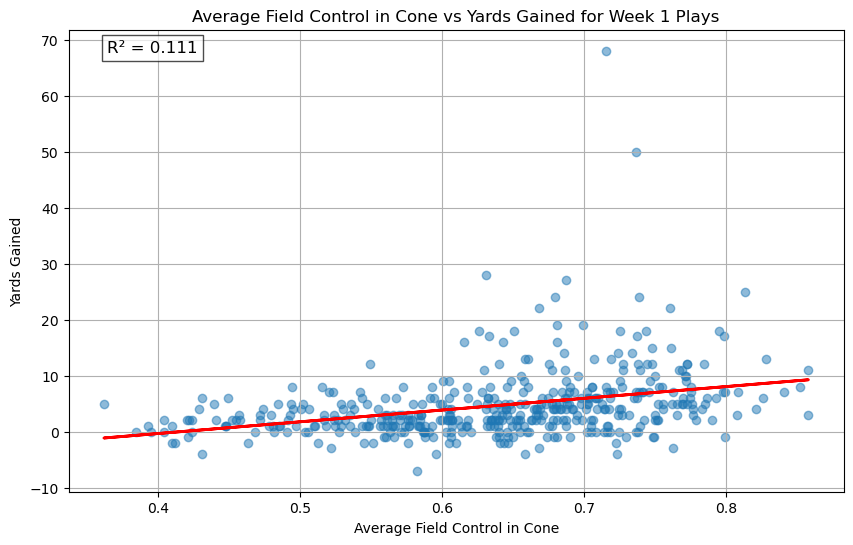

In [18]:
# plot the relationship
import matplotlib.pyplot as plt

plays_wk1 = plays.merge(
    pd.DataFrame.from_dict(play_results, orient='index', columns=['avg_field_control_in_cone']),
    left_on='game_play_id',
    right_index=True,
    how='left'
).dropna(subset=['avg_field_control_in_cone'])

x = 'avg_field_control_in_cone'

plt.figure(figsize=(10, 6))
plt.scatter(plays_wk1[x], plays_wk1['yards_gained'], alpha=0.5)
# best fit line
m, b = np.polyfit(plays_wk1[x], plays_wk1['yards_gained'], 1)
plt.plot(plays_wk1[x], m * plays_wk1[x] + b, color='red', linewidth=2, label='Best Fit Line')
# plot r squared
r2 = np.corrcoef(plays_wk1[x], plays_wk1['yards_gained'])[0, 1] ** 2
plt.text(0.05, 0.95, f'R² = {r2:.3f}', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.title('Average Field Control in Cone vs Yards Gained for Week 1 Plays')
plt.xlabel('Average Field Control in Cone')
plt.ylabel('Yards Gained')
plt.grid()
plt.show()

In [19]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(plays_wk1['avg_field_control_in_cone'], plays_wk1['yards_gained'])
print(f"p-value: {p_value:.20f}")

p-value: 0.00000000000087301670


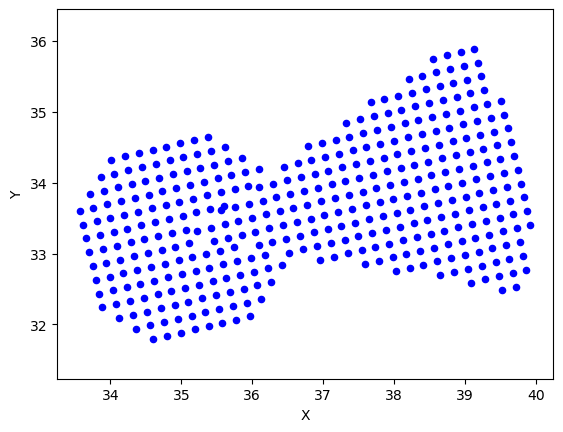

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
coords = np.array([[33.564, 33.603],
       [33.61 , 33.408],
       [33.656, 33.214],
       [33.702, 33.019],
       [33.713, 33.843],
       [33.748, 32.824],
       [33.759, 33.649],
       [33.794, 32.63 ],
       [33.805, 33.454],
       [33.839, 32.435],
       [33.851, 33.259],
       [33.862, 34.084],
       [33.885, 32.24 ],
       [33.896, 33.065],
       [33.907, 33.889],
       [33.942, 32.87 ],
       [33.953, 33.695],
       [33.988, 32.676],
       [33.999, 33.5  ],
       [34.01 , 34.325],
       [34.034, 32.481],
       [34.045, 33.305],
       [34.056, 34.13 ],
       [34.08 , 32.286],
       [34.091, 33.111],
       [34.102, 33.935],
       [34.126, 32.092],
       [34.137, 32.916],
       [34.148, 33.741],
       [34.183, 32.721],
       [34.194, 33.546],
       [34.205, 34.371],
       [34.229, 32.527],
       [34.24 , 33.351],
       [34.251, 34.176],
       [34.275, 32.332],
       [34.286, 33.157],
       [34.297, 33.981],
       [34.321, 32.137],
       [34.332, 32.962],
       [34.343, 33.787],
       [34.367, 31.943],
       [34.378, 32.767],
       [34.389, 33.592],
       [34.4  , 34.416],
       [34.423, 32.573],
       [34.434, 33.397],
       [34.446, 34.222],
       [34.469, 32.378],
       [34.48 , 33.203],
       [34.491, 34.027],
       [34.515, 32.183],
       [34.526, 33.008],
       [34.537, 33.832],
       [34.561, 31.989],
       [34.572, 32.813],
       [34.583, 33.638],
       [34.594, 34.462],
       [34.607, 31.794],
       [34.618, 32.619],
       [34.629, 33.443],
       [34.64 , 34.268],
       [34.664, 32.424],
       [34.675, 33.248],
       [34.686, 34.073],
       [34.71 , 32.229],
       [34.721, 33.054],
       [34.732, 33.878],
       [34.756, 32.035],
       [34.767, 32.859],
       [34.778, 33.684],
       [34.789, 34.508],
       [34.802, 31.84 ],
       [34.813, 32.664],
       [34.824, 33.489],
       [34.835, 34.314],
       [34.859, 32.47 ],
       [34.87 , 33.294],
       [34.881, 34.119],
       [34.905, 32.275],
       [34.916, 33.1  ],
       [34.927, 33.924],
       [34.951, 32.081],
       [34.962, 32.905],
       [34.973, 33.73 ],
       [34.984, 34.554],
       [34.996, 31.886],
       [35.007, 32.71 ],
       [35.018, 33.535],
       [35.029, 34.359],
       [35.053, 32.516],
       [35.064, 33.34 ],
       [35.075, 34.165],
       [35.099, 32.321],
       [35.11 , 33.146],
       [35.121, 33.97 ],
       [35.145, 32.126],
       [35.156, 32.951],
       [35.167, 33.776],
       [35.178, 34.6  ],
       [35.191, 31.932],
       [35.202, 32.756],
       [35.213, 33.581],
       [35.22 , 33.322],
       [35.224, 34.405],
       [35.248, 32.562],
       [35.27 , 34.211],
       [35.294, 32.367],
       [35.316, 34.016],
       [35.34 , 32.172],
       [35.351, 32.997],
       [35.362, 33.821],
       [35.373, 34.646],
       [35.386, 31.978],
       [35.397, 32.802],
       [35.408, 33.627],
       [35.414, 33.368],
       [35.419, 34.451],
       [35.443, 32.608],
       [35.46 , 33.174],
       [35.465, 34.257],
       [35.489, 32.413],
       [35.511, 34.062],
       [35.534, 32.218],
       [35.546, 33.043],
       [35.557, 33.867],
       [35.563, 33.609],
       [35.58 , 32.024],
       [35.591, 32.848],
       [35.602, 33.673],
       [35.609, 33.414],
       [35.613, 34.497],
       [35.637, 32.653],
       [35.655, 33.22 ],
       [35.659, 34.303],
       [35.683, 32.459],
       [35.705, 34.108],
       [35.729, 32.264],
       [35.74 , 33.089],
       [35.751, 33.913],
       [35.758, 33.655],
       [35.775, 32.069],
       [35.786, 32.894],
       [35.804, 33.46 ],
       [35.832, 32.699],
       [35.85 , 33.266],
       [35.854, 34.348],
       [35.878, 32.505],
       [35.9  , 34.154],
       [35.924, 32.31 ],
       [35.946, 33.959],
       [35.952, 33.701],
       [35.97 , 32.115],
       [35.981, 32.94 ],
       [35.998, 33.506],
       [36.027, 32.745],
       [36.044, 33.311],
       [36.073, 32.551],
       [36.09 , 33.117],
       [36.095, 34.2  ],
       [36.101, 33.941],
       [36.118, 32.356],
       [36.147, 33.747],
       [36.175, 32.986],
       [36.193, 33.552],
       [36.221, 32.791],
       [36.239, 33.357],
       [36.267, 32.597],
       [36.285, 33.163],
       [36.296, 33.987],
       [36.342, 33.793],
       [36.388, 33.598],
       [36.416, 32.837],
       [36.433, 33.403],
       [36.445, 34.228],
       [36.479, 33.209],
       [36.49 , 34.033],
       [36.525, 33.014],
       [36.536, 33.838],
       [36.582, 33.644],
       [36.628, 33.449],
       [36.639, 34.274],
       [36.674, 33.254],
       [36.685, 34.079],
       [36.72 , 33.06 ],
       [36.731, 33.884],
       [36.777, 33.69 ],
       [36.788, 34.514],
       [36.823, 33.495],
       [36.834, 34.32 ],
       [36.869, 33.3  ],
       [36.88 , 34.125],
       [36.915, 33.106],
       [36.926, 33.93 ],
       [36.961, 32.911],
       [36.972, 33.736],
       [36.983, 34.56 ],
       [37.017, 33.541],
       [37.028, 34.366],
       [37.063, 33.346],
       [37.074, 34.171],
       [37.109, 33.152],
       [37.12 , 33.976],
       [37.155, 32.957],
       [37.166, 33.782],
       [37.177, 34.606],
       [37.212, 33.587],
       [37.223, 34.411],
       [37.258, 33.392],
       [37.269, 34.217],
       [37.304, 33.198],
       [37.315, 34.022],
       [37.326, 34.847],
       [37.35 , 33.003],
       [37.361, 33.827],
       [37.372, 34.652],
       [37.407, 33.633],
       [37.418, 34.457],
       [37.453, 33.438],
       [37.464, 34.263],
       [37.499, 33.243],
       [37.51 , 34.068],
       [37.521, 34.893],
       [37.545, 33.049],
       [37.556, 33.873],
       [37.567, 34.698],
       [37.59 , 32.854],
       [37.601, 33.679],
       [37.612, 34.503],
       [37.647, 33.484],
       [37.658, 34.309],
       [37.669, 35.133],
       [37.693, 33.289],
       [37.704, 34.114],
       [37.715, 34.938],
       [37.739, 33.095],
       [37.75 , 33.919],
       [37.761, 34.744],
       [37.785, 32.9  ],
       [37.796, 33.725],
       [37.807, 34.549],
       [37.842, 33.53 ],
       [37.853, 34.354],
       [37.864, 35.179],
       [37.888, 33.335],
       [37.899, 34.16 ],
       [37.91 , 34.984],
       [37.934, 33.141],
       [37.945, 33.965],
       [37.956, 34.79 ],
       [37.98 , 32.946],
       [37.991, 33.77 ],
       [38.002, 34.595],
       [38.026, 32.751],
       [38.037, 33.576],
       [38.048, 34.4  ],
       [38.059, 35.225],
       [38.083, 33.381],
       [38.094, 34.206],
       [38.105, 35.03 ],
       [38.128, 33.187],
       [38.14 , 34.011],
       [38.151, 34.836],
       [38.174, 32.992],
       [38.185, 33.816],
       [38.196, 34.641],
       [38.207, 35.465],
       [38.22 , 32.797],
       [38.231, 33.622],
       [38.242, 34.446],
       [38.253, 35.271],
       [38.277, 33.427],
       [38.288, 34.252],
       [38.299, 35.076],
       [38.323, 33.232],
       [38.334, 34.057],
       [38.345, 34.882],
       [38.369, 33.038],
       [38.38 , 33.862],
       [38.391, 34.687],
       [38.402, 35.511],
       [38.415, 32.843],
       [38.426, 33.668],
       [38.437, 34.492],
       [38.448, 35.317],
       [38.472, 33.473],
       [38.483, 34.298],
       [38.494, 35.122],
       [38.518, 33.278],
       [38.529, 34.103],
       [38.54 , 34.927],
       [38.551, 35.752],
       [38.564, 33.084],
       [38.575, 33.908],
       [38.586, 34.733],
       [38.597, 35.557],
       [38.61 , 32.889],
       [38.621, 33.714],
       [38.632, 34.538],
       [38.643, 35.363],
       [38.656, 32.694],
       [38.667, 33.519],
       [38.678, 34.343],
       [38.689, 35.168],
       [38.712, 33.324],
       [38.723, 34.149],
       [38.735, 34.973],
       [38.746, 35.798],
       [38.758, 33.13 ],
       [38.769, 33.954],
       [38.78 , 34.779],
       [38.791, 35.603],
       [38.804, 32.935],
       [38.815, 33.759],
       [38.826, 34.584],
       [38.837, 35.409],
       [38.85 , 32.74 ],
       [38.861, 33.565],
       [38.872, 34.389],
       [38.883, 35.214],
       [38.907, 33.37 ],
       [38.918, 34.195],
       [38.929, 35.019],
       [38.94 , 35.844],
       [38.953, 33.175],
       [38.964, 34.   ],
       [38.975, 34.825],
       [38.986, 35.649],
       [38.999, 32.981],
       [39.01 , 33.805],
       [39.021, 34.63 ],
       [39.032, 35.454],
       [39.045, 32.786],
       [39.056, 33.611],
       [39.067, 34.435],
       [39.078, 35.26 ],
       [39.091, 32.592],
       [39.102, 33.416],
       [39.113, 34.241],
       [39.124, 35.065],
       [39.135, 35.89 ],
       [39.148, 33.221],
       [39.159, 34.046],
       [39.17 , 34.87 ],
       [39.181, 35.695],
       [39.194, 33.027],
       [39.205, 33.851],
       [39.216, 34.676],
       [39.227, 35.5  ],
       [39.24 , 32.832],
       [39.251, 33.657],
       [39.262, 34.481],
       [39.273, 35.306],
       [39.285, 32.637],
       [39.296, 33.462],
       [39.307, 34.287],
       [39.319, 35.111],
       [39.342, 33.267],
       [39.353, 34.092],
       [39.364, 34.916],
       [39.388, 33.073],
       [39.399, 33.897],
       [39.41 , 34.722],
       [39.434, 32.878],
       [39.445, 33.703],
       [39.456, 34.527],
       [39.48 , 32.683],
       [39.491, 33.508],
       [39.502, 34.332],
       [39.513, 35.157],
       [39.526, 32.489],
       [39.537, 33.313],
       [39.548, 34.138],
       [39.559, 34.962],
       [39.583, 33.119],
       [39.594, 33.943],
       [39.605, 34.768],
       [39.629, 32.924],
       [39.64 , 33.748],
       [39.651, 34.573],
       [39.675, 32.729],
       [39.686, 33.554],
       [39.697, 34.378],
       [39.721, 32.535],
       [39.732, 33.359],
       [39.743, 34.184],
       [39.778, 33.164],
       [39.789, 33.989],
       [39.823, 32.97 ],
       [39.835, 33.794],
       [39.869, 32.775],
       [39.88 , 33.6  ],
       [39.926, 33.405]])

# Scatter plot
plt.scatter(coords[:, 0], coords[:, 1], c='blue', s=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')  # Keep aspect ratio
plt.show()


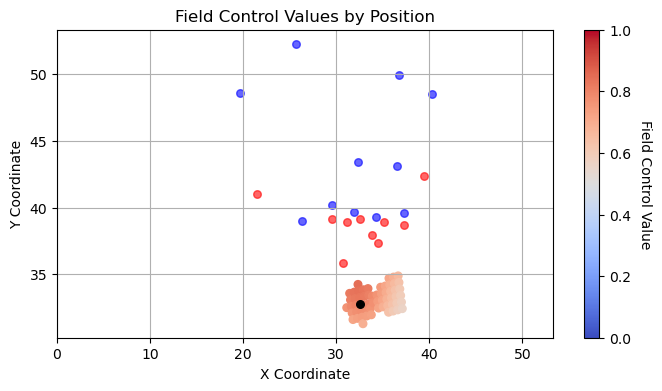

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Provided data
values = np.array([0.76567463, 0.82184458, 0.80928795, 0.7895206 , 0.75959334,
       0.71919362, 0.83354941, 0.82220762, 0.80381146, 0.77473839,
       0.73404386, 0.84499473, 0.83596426, 0.82556171, 0.78057224,
       0.7404178 , 0.69085225, 0.83010372, 0.79978629, 0.82009939,
       0.77732474, 0.73826998, 0.81694934, 0.78950131, 0.80658701,
       0.76555458, 0.72808597, 0.78877386, 0.77115707, 0.76345218,
       0.74595417, 0.71943167, 0.74849538, 0.73330176, 0.71567769,
       0.69093695, 0.71805538, 0.70043176, 0.68259713, 0.65991878,
       0.63172548, 0.71515831, 0.68708729, 0.6672218 , 0.64933052,
       0.62902714, 0.6051678 , 0.68811806, 0.65738196, 0.63586037,
       0.61825234, 0.60038079, 0.58083965, 0.66207286, 0.6300317 ,
       0.60789781, 0.59100704, 0.57554867, 0.55993374])

coords = np.array([[31.134, 32.482],
       [31.447, 33.555],
       [31.537, 33.063],
       [31.626, 32.571],
       [31.715, 32.079],
       [31.805, 31.587],
       [31.939, 33.645],
       [32.029, 33.153],
       [32.118, 32.661],
       [32.207, 32.169],
       [32.297, 31.677],
       [32.342, 34.226],
       [32.431, 33.734],
       [32.521, 33.242],
       [32.699, 32.258],
       [32.789, 31.766],
       [32.878, 31.274],
       [32.923, 33.823],
       [32.988, 32.675],
       [33.013, 33.331],
       [33.191, 32.347],
       [33.281, 31.855],
       [33.415, 33.913],
       [33.48 , 32.765],
       [33.505, 33.421],
       [33.683, 32.437],
       [33.773, 31.945],
       [33.883, 33.346],
       [33.972, 32.854],
       [34.375, 33.435],
       [34.464, 32.943],
       [34.554, 32.451],
       [34.778, 34.017],
       [34.867, 33.525],
       [34.956, 33.033],
       [35.046, 32.541],
       [35.27 , 34.106],
       [35.359, 33.614],
       [35.448, 33.122],
       [35.538, 32.63 ],
       [35.627, 32.138],
       [35.672, 34.687],
       [35.762, 34.195],
       [35.851, 33.703],
       [35.94 , 33.211],
       [36.029, 32.719],
       [36.119, 32.227],
       [36.164, 34.776],
       [36.253, 34.285],
       [36.343, 33.793],
       [36.432, 33.301],
       [36.521, 32.809],
       [36.611, 32.317],
       [36.656, 34.866],
       [36.745, 34.374],
       [36.835, 33.882],
       [36.924, 33.39 ],
       [37.013, 32.898],
       [37.103, 32.406]])

# Create scatter plot
from matplotlib import colors

plt.figure(figsize=(8, 4))
norm = colors.Normalize(vmin=0, vmax=1)  # 0 → min color, 1 → max color
sc = plt.scatter(
    coords[:, 0], coords[:, 1],
    c=values,
    cmap='coolwarm',
    norm=norm,
    s=30
)
# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Field Control Value", rotation=270, labelpad=15)

# plot 2022091200_64 game_play_id, offense is blue, defense is green
players = tracking.query('game_play_id == "2022091200_64" and club != "football" and frame_id == 124')
plt.scatter(players.query('~defense and is_ball_carrier==0')['x'], players.query('~defense and is_ball_carrier==0')['y'], 
            color='red', label='Offense', alpha=0.6, s=30)
plt.scatter(players.query('defense')['x'], players.query('defense')['y'], 
            color='blue', label='Defense', alpha=0.6, s=30)
# plot ball carrier in black
ball_carrier = players.query('is_ball_carrier == 1')
if not ball_carrier.empty:
    plt.scatter(ball_carrier['x'], ball_carrier['y'], color='black', label='Ball Carrier', s=30, edgecolors='k')



# Labels and aesthetics
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Field Control Values by Position")
plt.grid(True)

plt.xlim(0, 53.3)

plt.show()
